In this Python notebook we will try to use vision transformer as another method to implement our classification plants & diseases task.
This code is based on the ideas that presented on the paper - "An Image Is Worth 16x16 Words"

part 1 - useful imports and functions:

In [54]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms

def divide_to_patches(image, patch_size=16):
    image_width, image_height = image.shape[1], image.shape[2]
    num_of_patches = (image_width // patch_size) * (image_height // patch_size)
    print(num_of_patches)
    print(image.shape)
    patches = np.zeros((num_of_patches, 3, patch_size, patch_size))
    print(patches.shape)
    for k in range(num_of_patches):
        for i in range(14):
            for j in range(14):
                patches[k, 0:3, 0 : 16, 0 : 16] = image[0:3, i*16 : (i+1)*16, j*16 : (j+1)*16]
    return torch.Tensor(patches)
                
            
            
            


def show_image_patches(patches: torch.Tensor):
    #patches = patches.permute(1, 2, 0).detach().numpy()
    #print(pa)
    #fig, axes = plt.subplots(14, 14, figsize=(10, 10))
    #for k in range(196):
    #for i in range(0, 14, 1):
    #    for j in range(0, 14, 1):
    #    axes[int(k/196), k%196].imshow(patches[k, :, :, :])
        #axes[i, j].axis('off')
    #ax.imshow(img, cmap='gray')
    #plt.tight_layout()
    #plt.show()
    num_images = patches.shape[0]
    num_cols = 14  # Number of columns for visualization
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_images):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(patches[i].permute(1, 2, 0))  # Transpose for correct visualization
        ax.axis('off')

    plt.tight_layout()
    plt.show()




part 2 - loading the dataset:

In [11]:
local_root_dir = 'Dataset/PlantVillage'

dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

classes = ["Apple, Scab", "Apple, Black rot", "Apple, Cedar rust", "Apple, Healthy", "Blueberry, Healthy",
           "Cherry, Healthy", "Cherry, Powdery mildew", "Corn, Cercospora spot", "Corn, Common rust",
           "Corn, Healthy", "Corn Northern Leaf Blight", "Grape, Black rot", "Grape, Esca", "Grape, Healthy",
           "Grape, Leaf blight (Isariposis)", "Orange, Haunglongbing", "Peach, Bacterial spot",
           "Peach, Healthy", "Pepper, Bacterial spot", "Pepper, Healthy", "Potato, Early Blight",
           "Potato, Healthy", "Potato, Late Blight", "Raspberry, Healthy", "Soybean, Healthy",
           "Squash, Powdery mildew", "Strawberry, Healthy", "Strawberry, Leaf Scorch", "Tomato, Bacterial spot",
           "Tomato, Early Blight", "Tomato, Healthy", "Tomato, Late Blight", "Tomato, Leaf Mold",
           "Tomato, Septoria leaf spot", "Tomato, Spider mites", "Tomato, Target spot", "Tomato, Moasic virus",
           "Tomato, Yellow leaf curl virus"]

dataset = datasets.ImageFolder(root=local_root_dir + '/train',transform=dataset_transform)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = int(0.1 * dataset_size)
valid_size = dataset_size - train_size - test_size
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")


train dataset has 34755 samples
validation dataset has 4345 samples
test dataset has 4344 samples


part 3 - preparing the data for the encoder:

According to the paper it is required to split the input images to patches. We will use the same size as suggested - 16x16 patches.
The images are with size of (224,224), therefore each image will have $\frac{224}{16}$ $\cdot$ $\frac{224}{16}$ = $14$$\cdot$$14$ = $196$ patches.
Now, in order to divide the image to patches, we will use Conv2D layer with 0 padding, stride 16 (patch size) and kernel size of 16$\times$16. 

196
torch.Size([3, 224, 224])
(196, 3, 16, 16)
torch.Size([196, 3, 16, 16])
<class 'torch.Tensor'>
tensor([[[[0.4353, 0.4275, 0.4196,  ..., 0.4039, 0.4157, 0.4471],
          [0.3922, 0.4078, 0.4039,  ..., 0.4000, 0.3843, 0.4196],
          [0.4118, 0.4314, 0.4000,  ..., 0.3961, 0.3922, 0.4000],
          ...,
          [0.3922, 0.4157, 0.4039,  ..., 0.3882, 0.3922, 0.4314],
          [0.3804, 0.3686, 0.3725,  ..., 0.3765, 0.3686, 0.4000],
          [0.4039, 0.3804, 0.3804,  ..., 0.4235, 0.3725, 0.3490]],

         [[0.3843, 0.3765, 0.3686,  ..., 0.3529, 0.3647, 0.3961],
          [0.3412, 0.3569, 0.3529,  ..., 0.3490, 0.3333, 0.3686],
          [0.3608, 0.3804, 0.3490,  ..., 0.3451, 0.3412, 0.3490],
          ...,
          [0.3412, 0.3647, 0.3529,  ..., 0.3373, 0.3412, 0.3804],
          [0.3294, 0.3176, 0.3216,  ..., 0.3255, 0.3176, 0.3490],
          [0.3529, 0.3294, 0.3294,  ..., 0.3725, 0.3216, 0.2980]],

         [[0.4118, 0.4078, 0.4039,  ..., 0.3882, 0.4000, 0.4314],
         

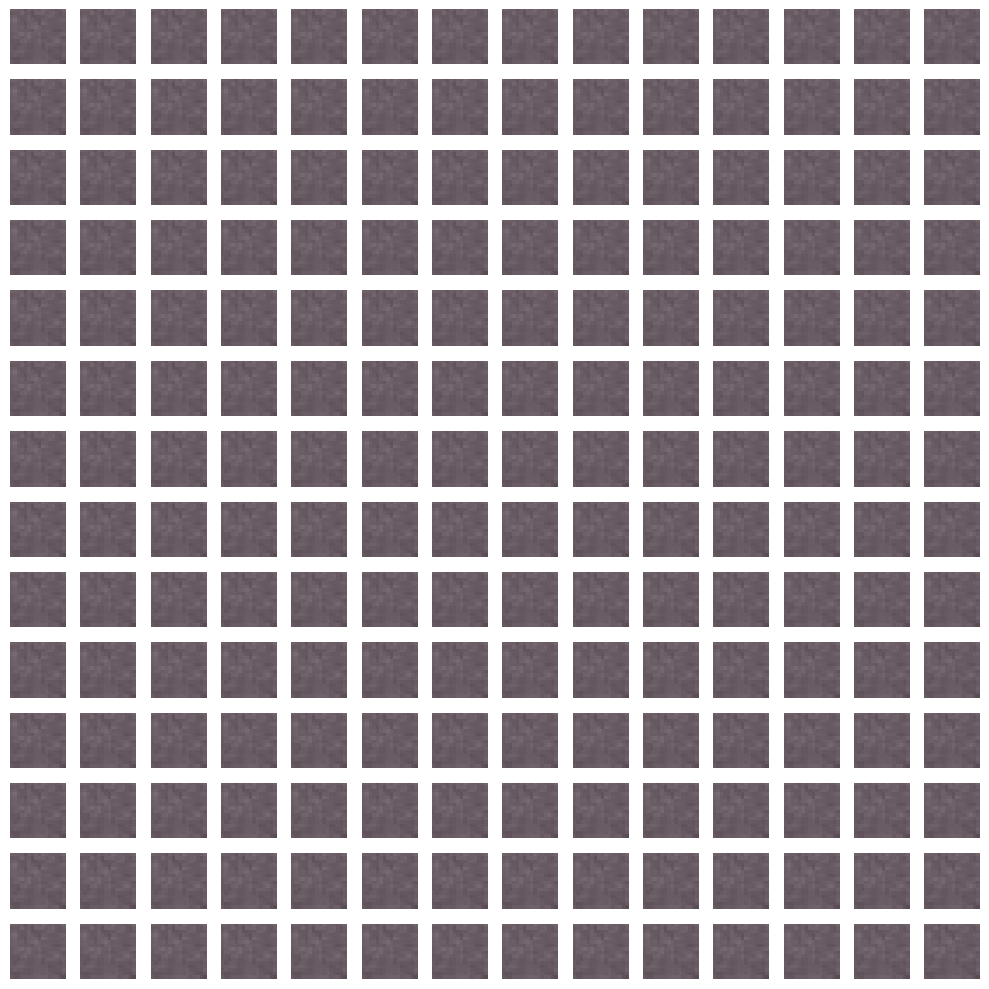

In [55]:
# Making an identity kernel for RGB image
#identity_kernel = torch.eye(16, dtype=torch.float32).unsqueeze(0).expand(3, 16, 16)
#identity_kernel = torch.eye(16, dtype=torch.float32)
#print(identity_kernel.shape)
patch_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=16, stride=16, padding=0, bias=False)
#output_patched_image = patch_layer(train_set[0][0])
output_patched_image = divide_to_patches(train_set[0][0])
#output_patched_image_flat = nn.Flatten(start_dim=2, end_dim=3)(train_set[0][0])
#show_image(train_set[0][0])
print(output_patched_image.shape)
print(type(output_patched_image))
print(output_patched_image)
show_image_patches(output_patched_image)


In [7]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1)

In [8]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
image = train_set[0][0]
# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])
tensor([[[-0.4436,  0.0986, -0.1466,  ...,  0.3383, -0.2058,  0.1812],
         [-0.4684,  0.1375, -0.1555,  ...,  0.3313, -0.1945,  0.1416],
         [-0.4697,  0.1047, -0.1510,  ...,  0.3478, -0.2240,  0.1929],
         ...,
         [-0.6205,  0.1581, -0.1788,  ...,  0.4938, -0.2767,  0.2064],
         [-0.6212,  0.1571, -0.1868,  ...,  0.4744, -0.2865,  0.2266],
         [-0.6189,  0.1602, -0.1828,  ...,  0.4689, -0.2730,  0.2089]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768])
